# Libraries

In [62]:
import warnings
warnings.filterwarnings( 'ignore' )

## Import libraries

In [63]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import random
import pandas    as pd
import numpy     as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# Torch libraries
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.EarlyStopping      import *
from utils.LRScheduler        import *
#
from utils.DLinear_utils      import *
from models.DLinear.DLinear   import *

# Parameters

In [64]:
import random
import os
# Set seed
#
seed = 1999
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## CUDA

In [65]:
# device = torch.device( 'cpu' )
try:
    torch.cuda.init()

    if (torch.cuda.is_available() == True):
        print('[INFO] CUDA is available')

        device = torch.device( 'cuda:0' )
        print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))

    else:
        print('[INFO] CUDA is not available')
        device = torch.device( 'cpu' )
except:
    print('[INFO] CUDA is not available')
    device = torch.device( 'cpu' )

[INFO] CUDA is not available


## Neural networks parameters

In [66]:
class Parameters():
    def __init__(self):
        self.description = 'DLinear model for time-series forecasting'
    
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Neural network model parameters
        #
        # Input sequence length - look-back
        self.Lag         = 12
        # Prediction sequence length
        self.Horizon     =  2
        #
        self.individual  = False
        self.enc_in      =  2
        self.kernel_size = 25
        
        # Training parameters
        #
        # Number of epochs
        self.epochs        = 1000
        # Batch size
        self.batch_size    = 128
        # Number of workers in DataLoader
        self.num_workers   = 0
        # Define verbose
        self.verbose       = True
        # Learning rate
        self.learning_rate = 1e-4
        # Weight decay
        self.weight_decay  = 0.00001        
        # Clip gradient
        self.clip_grads      = False
        # Norm for clip gradient                
        self.clip_grads_norm = 0.5        
        # Trained model path
        self.model_path    = 'checkpoints/DLinear.pth'
        
        # Data handling
        #
        # Filename
        self.filename              = '../../metadata/7-kanal-1.csv'
        # Target series name 
        self.targetSeries          = 'CO'
        # Data Log-transformation
        self.Transformation        = True
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'
        # Smoothing
        self.Smoothing             = False
        #
        self.window_len  = 2        # [2, 10]
        self.window_type = 'bartlett' # ['ones', 'hanning', 'hamming', 'bartlett', 'blackman']
        # Data Augmentation
        self.DataAugmentation = True
        
args = Parameters()

# Data handling

## Import data


In [67]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( args.filename )


print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head( 3 )

[INFO] Data imported
[INFO] Time: 0.39 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [68]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

# Resample Dataset
#
df = df.resample('10min').mean()


# Keep only selected time-series
#
df = pd.DataFrame( df[ [ args.targetSeries ] ] )


df.head( 3 )

,CO
Date,
2022-02-19 00:00:00,240.710526
2022-02-19 00:10:00,227.473684
2022-02-19 00:20:00,229.526316


### Split Training/Testing

In [69]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ] 
df_test  = df[ idx: ] 

### Visualization

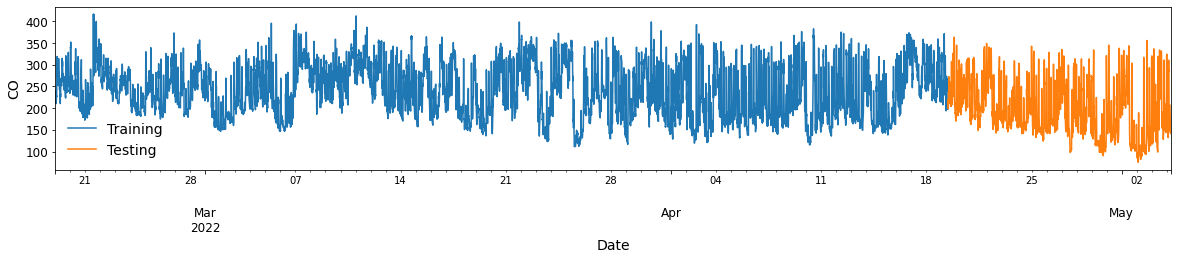

In [70]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ args.targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ args.targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(args.targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fix Lag

In [71]:
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])

## Preprocessing

### Data Transformation

In [72]:
if (args.Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    
    df_train  = np.log( df_train + VALUE)
    df_test   = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Scaling

In [73]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
       
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
            
elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
       
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
        
elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )             
    
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   

[INFO] Scaling: Standard


## Create Training/Testing data

In [74]:
trainX, trainY, trainTime  = create_dataset(df           = df_train, 
                                            Lag          = args.Lag, 
                                            Horizon      = args.Horizon, 
                                            targetSeries = args.targetSeries,
                                            overlap      = args.Horizon,)


testX,  testY, testDate,   = create_dataset(df           = df_test, 
                                            Lag          = args.Lag, 
                                            Horizon      = args.Horizon, 
                                            targetSeries = args.targetSeries,
                                            overlap      = args.Horizon,)



# # Last 10% of the training data will be used for validation
# #
idx = int(0.9 * trainX.shape[0])
validX, validY, validTime = trainX[ idx: ], trainY[ idx: ], trainTime[ idx: ]
trainX, trainY, trainTime = trainX[ :idx ], trainY[ :idx ], trainTime[ :idx ]

print('Training data shape:   ', trainX.shape, trainY.shape)
print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

100%|██████████| 1070/1070 [00:00<00:00, 8244.72it/s]

Training data shape:    (3845, 12, 1) (3845, 2)
Validation data shape:  (428, 12, 1) (428, 2)
Testing data shape:     (1070, 12, 1) (1070, 2)


## Data augmentation

### Part I

In [75]:
# X = []
# for i in tqdm( range(trainX.shape[0]) ):
#     Instance = trainX[i]
    
#     X.append( np.concatenate([Instance[24:48], Instance[0:24], Instance[48:]], axis = 0) )
    

# for i in tqdm( range(trainX.shape[0]) ):
#     Instance = trainX[i]
    
#     X.append( np.concatenate([Instance[48:], Instance[:48]], axis = 0) )
    
# # Convert to ndarray
# X = np.array( X )


# #
# trainX     = np.concatenate( [trainX, X], axis = 0)
# trainY     = np.concatenate( [trainY, trainY, trainY], axis = 0)

### Part II

In [76]:
if ( args.DataAugmentation ):
    augmentation = DataAugmentation( df_train, args )


    X , Y = augmentation.createInstances(3, 'hamming')

    # Concatenate with training data
    #
    trainX     = np.concatenate( [trainX, X], axis = 0)
    trainY     = np.concatenate( [trainY, Y], axis = 0)


    X , Y = augmentation.createInstances(5, 'hamming')

    # Concatenate with training data
    #
    trainX     = np.concatenate( [trainX, X], axis = 0)
    trainY     = np.concatenate( [trainY, Y], axis = 0)    

[INFO] Data Augmentation using Smoothing (ConvolutionSmoother) is setup


100%|██████████| 4273/4273 [00:00<00:00, 7523.56it/s]


## Create DataLoader

In [77]:
class Data( Dataset ):
    def __init__(self, X, Y):
        self.X    = X
        self.Y    = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[ idx ], self.Y[ idx ]
    

    
# Create training and test dataloaders
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY )


# Prepare Data-Loaders
#
train_dl = DataLoader(train_ds, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = True)
test_dl  = DataLoader(test_ds,  batch_size = args.batch_size, num_workers = args.num_workers, shuffle = False)
#
print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# Forecasting model: DLinear

## Setup model

In [78]:
# Initialize Neural Network
# 
model = DLinear( args )

model.to( device )


print( model )

DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=12, out_features=2, bias=True)
  (Linear_Trend): Linear(in_features=12, out_features=2, bias=True)
  (Linear_Decoder): Linear(in_features=12, out_features=2, bias=True)
)


## Training parameters

In [79]:
# Specify loss function
#
criterion = nn.MSELoss()
# criterion = nn.L1Loss()


# Specify loss function
#
optimizer = torch.optim.Adam(params       = model.parameters(), 
                             lr           = args.learning_rate,
                             weight_decay = args.weight_decay)


# Early stopping
#
early_stopping = EarlyStopping(patience  = 50,
                               min_delta = 1.0e-5)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 10, 
                        min_lr    = 1e-10, 
                        factor    = 0.5, 
                        verbose   = args.verbose)

## Training process

In [80]:
# Store training and validation loss
Loss = {
         'Train': [], 
         'Valid':  []
       }



# Main loop - Training process
#
for epoch in range(1, args.epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor training loss
    #
    train_loss = 0.0
    valid_loss = 0.0    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data, target in train_dl:
        
        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()

            
        outputs = model( data ).squeeze(-1)
        

        
        # Calculate the loss
        #
        loss = criterion(outputs, target)
        
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        # Clip gradients
        #
        if ( args.clip_grads ):
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grads_norm)
            
            
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item()*data.size(0)
               
        # Increase batch_idx
        #
        batch_idx  += 1
        
        
           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / train_dl.dataset.X.shape[0]

    
    
    
    
    with torch.no_grad():
        for data, target in valid_dl:

            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if (device.type == 'cpu'):
                data   = torch.tensor(data, dtype=torch.float32)
                target = torch.tensor(target, dtype=torch.float32)
            else:
                data   = torch.tensor(data, dtype=torch.float32).cuda()
                target = torch.tensor(target, dtype=torch.float32).cuda()


            outputs = model( data ).squeeze(-1)
        
          

            # Calculate the loss
            #
            loss = criterion(outputs, target)
                
            # update running training loss
            valid_loss += loss.item()*data.size(0)
              

    # Print avg training statistics 
    #
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]






    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('[INFO] Epoch: {:3.0f} Train Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(epoch, train_loss, valid_loss, stop-start), end=' ')

 
    

    # Update best model
    #
    if (epoch == 1):
        Best_score = valid_loss
        
        torch.save(model.state_dict(), args.model_path)
        print('(Model saved)')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss
            
            torch.save(model.state_dict(), args.model_path)
            print('(Model saved)')
        else:
            print( )
     
    
    # Store train/val loss
    #
    Loss['Train'] += [ train_loss ]
    Loss['Valid'] += [ valid_loss ]
    

    
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler( valid_loss )
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping( valid_loss ) ): break

[INFO] Epoch:   1 Train Loss: 0.543034	Valid Loss: 0.207511 	Time: 0.21secs (Model saved)
[INFO] Epoch:   2 Train Loss: 0.501486	Valid Loss: 0.193401 	Time: 0.20secs (Model saved)
[INFO] Epoch:   3 Train Loss: 0.465522	Valid Loss: 0.180874 	Time: 0.20secs (Model saved)
[INFO] Epoch:   4 Train Loss: 0.433496	Valid Loss: 0.169617 	Time: 0.18secs (Model saved)
[INFO] Epoch:   5 Train Loss: 0.404856	Valid Loss: 0.159615 	Time: 0.23secs (Model saved)
[INFO] Epoch:   6 Train Loss: 0.379291	Valid Loss: 0.150654 	Time: 0.23secs (Model saved)
[INFO] Epoch:   7 Train Loss: 0.356348	Valid Loss: 0.142636 	Time: 0.19secs (Model saved)
[INFO] Epoch:   8 Train Loss: 0.335783	Valid Loss: 0.135515 	Time: 0.23secs (Model saved)
[INFO] Epoch:   9 Train Loss: 0.317401	Valid Loss: 0.129159 	Time: 0.21secs (Model saved)
[INFO] Epoch:  10 Train Loss: 0.300993	Valid Loss: 0.123476 	Time: 0.22secs (Model saved)
[INFO] Epoch:  11 Train Loss: 0.286384	Valid Loss: 0.118503 	Time: 0.27secs (Model saved)
[INFO] Epo

## Load optimized model

In [81]:
# Load best model
#
model.load_state_dict( torch.load( args.model_path ) );
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [82]:
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):

        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()
            

        if (pred is None):
            pred = model( data ).squeeze(-1).cpu().detach().numpy()
        else:
            pred = np.concatenate([ pred, model( data ).squeeze(-1).cpu().detach().numpy() ])

100%|██████████| 9/9 [00:00<00:00, 678.69it/s]


### Apply inverse scaling/transformation

In [83]:
# Apply inverse scaling
#
for i in range( args.Horizon ):
    testY[:,  i]  = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]    = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (args.Transformation == True):
    testY  = np.exp( testY ) - VALUE
    pred   = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [84]:
print('[INFO] Feature: ', args.targetSeries)
print('------------------------------------------------')
Prices = pd.DataFrame([])        

Prices[ args.targetSeries ] = testY.flatten()
Prices[ 'Prediction'      ] = pred.flatten()

# Evaluation
#
MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

print('    - \t    MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f\n' % (MAE, RMSE, SMAPE, R2) )

Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( args.Horizon ):

    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
    - 	    MAE 21.93 RMSE 33.52 SMAPE: 10.86 R2: 0.71

Horizon:  1 MAE 16.26 RMSE 25.57 SMAPE:  7.93 R2: 0.83
Horizon:  2 MAE 27.61 RMSE 39.92 SMAPE: 13.78 R2: 0.59


## Visualization

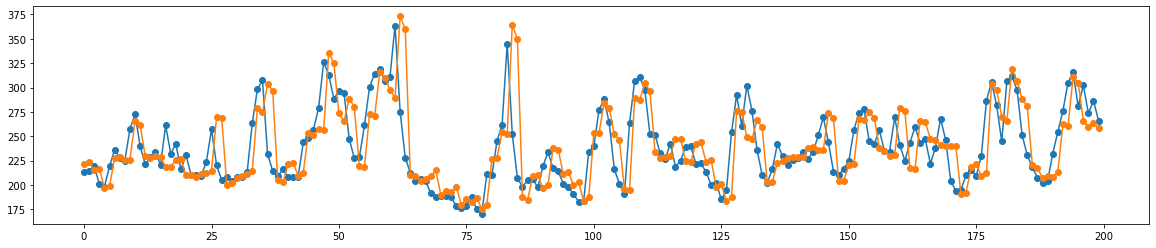

In [85]:
Prices = pd.DataFrame( [] )

Prices[ args.targetSeries ] = testY.flatten()
Prices[ 'Prediction'      ] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ args.targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction'      ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();


### Examples

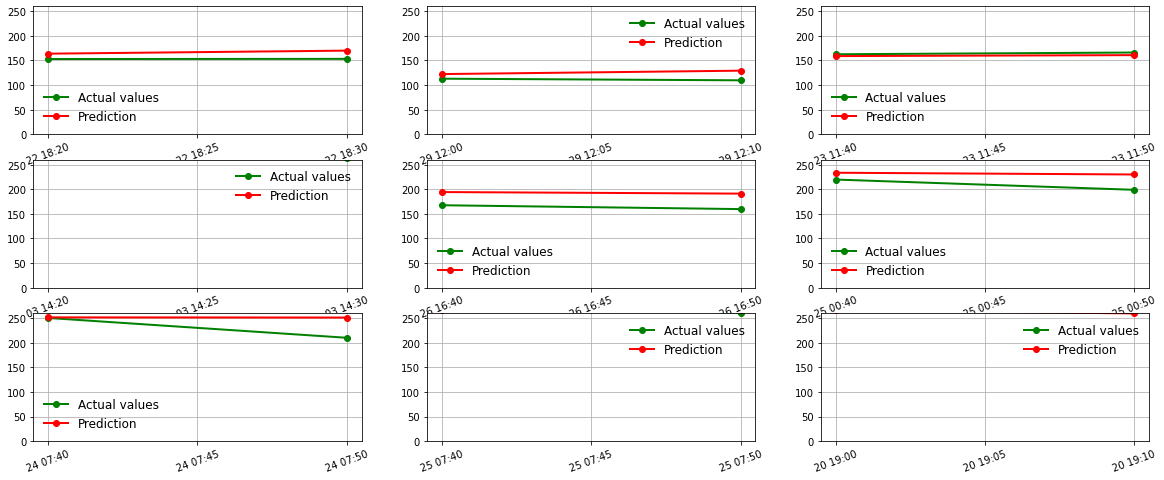

In [86]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )

# Select random cases
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
# RandomInstances = [51, 44, 154, 53, 166, 13, 104, 102, 24]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
    plt.plot(testDate[i], testY[i], color = 'g', marker = 'o', linewidth = 2)
    plt.plot(testDate[i], pred[i],  color = 'r', marker = 'o', linewidth = 2)
    

    
    plt.legend(['Actual values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([0, 260])
    plt.xticks(rotation = 20)
plt.show()

# Store predictions

In [87]:
Outputs = pd.DataFrame( [] )


Outputs[ args.targetSeries ] = testY.flatten()
Outputs[ 'DLinear'         ] = pred.flatten()

Outputs.to_csv('../Predictions/DLinear.csv')